In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output
import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
from torch.autograd import Variable
import PIL
import torch.optim as optim

In [2]:
# initialize the dataloader and normalize the data 
class Dataset:
    """load the image / encoded object position representation pairs for training and testing data"""
    def __init__(self, path, mode = 'train'):
        self.path=path
        self.mode=mode
    def __getitem__(self, index):
        mode = self.mode
        if mode=='train':
            fname = '/train-%04d.jpg'
        elif mode=='test':
            fname = '/test-%04d.jpg'
            
        if mode=='train':
            fname1 = 'train-comp-%04d.npy'
        elif mode=='test':
            fname1 = 'test-comp-%04d.npy'
        img = PIL.Image.open(self.path+fname%index)
        vect = np.load(self.path+fname1%index)
        transform = transforms.Compose([#transforms.Scale((227,227)),
                                        transforms.ToTensor(),
                                        #transforms.Normalize(mean=[0.5],std=[0.25])
                                       ])
        img = transform(img)
        if mode=='train':
            img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

# Initialize dataset iterators and find gpu if available 
train_data = Dataset('./data/training/',mode='train')
test_data = Dataset('./data/testing/',mode='test')
print('data is loaded')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is '+ str(device))

data is loaded
device is cuda:0


In [3]:
class Net(nn.Module):
    """ this is lenet adapted to the problem """
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 6, 7, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(6, 16, 5, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(16, 120, 5, 1),
            nn.ReLU(inplace=True)
                                    )
        self.fc = nn.Sequential(
            nn.Linear(120*13**2, 5000),
            nn.ReLU(),
            nn.Linear(5000, 500),
                                )
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, 120*13**2)
        output = self.fc(output)
        return output

In [4]:
model = Net().to(device).train()

In [17]:
# initialize the model 
#model = Net().to(device).train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
#losses = []

# set up the training loop and dataset iterator 
k = 250 #size of batch 
N = 500 #number epochs
b = int(len(train_data)/k) #number of batches
train_loader = DataLoader(train_data , batch_size = k, shuffle = True) #batch data loader

# train the network 
for epoch in range(N): # epoch iterator 
    epoch_loss = 0 # mean loss per epoch 
    for i, (inputs, targets) in enumerate(train_loader): # batch iterator 
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # model prediction
        loss = criterion(outputs,targets)  # loss computation
        loss.backward() # backpropagation
        optimizer.step() # gradient descent 
        epoch_loss+=loss.cpu().data.item() # pull the batch losses 
    epoch_loss /= i
    print('epoch loss: ',round(epoch_loss,2)) # print/store loss
    if epoch%10==0 and epoch!=0:     
        n = epoch
        #torch.save(model,'./partial-trains/%04d-epochs.pt'%n) # save partially trained model 
    losses.append(epoch_loss) # keep the losses 
    scheduler.step(epoch_loss) # possibly modify the learning rate 

epoch loss:  20183.13
epoch loss:  17291.42
epoch loss:  9781.3
epoch loss:  6205.42
epoch loss:  5514.76
epoch loss:  3972.77
epoch loss:  2997.39
epoch loss:  2205.11
epoch loss:  1622.41
epoch loss:  1239.1
epoch loss:  900.49
epoch loss:  724.21
epoch loss:  565.02
epoch loss:  433.98
epoch loss:  349.12
epoch loss:  290.86
epoch loss:  245.98
epoch loss:  217.08
epoch loss:  190.16
epoch loss:  168.36
epoch loss:  150.26
epoch loss:  136.76
epoch loss:  127.85
epoch loss:  119.78
epoch loss:  112.62
epoch loss:  107.64
epoch loss:  102.37
epoch loss:  98.01
epoch loss:  94.4
epoch loss:  91.28
epoch loss:  88.73
epoch loss:  86.17
epoch loss:  83.82
epoch loss:  81.74
epoch loss:  79.94
epoch loss:  77.95
epoch loss:  76.22
epoch loss:  74.67
epoch loss:  73.2
epoch loss:  71.73
epoch loss:  70.39
epoch loss:  69.11
epoch loss:  67.91
epoch loss:  66.77
epoch loss:  65.72
epoch loss:  64.68
epoch loss:  63.7
epoch loss:  62.71
epoch loss:  61.73
epoch loss:  60.83
epoch loss:  59.

KeyboardInterrupt: 

In [18]:
epoch

188

In [20]:
torch.save(model,'1188epochs.pt')

/home/kpierce/jupyter_py3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
model.eval()

Net(
  (convnet): Sequential(
    (0): Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=20280, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=500, bias=True)
  )
)

In [55]:
test_loader = DataLoader(test_data , batch_size = k, shuffle = True) #batch data loader
for i,(x,y) in enumerate(test_loader):
    break

In [57]:
y_ = model(x).detach().numpy()

In [58]:
y = y.numpy()

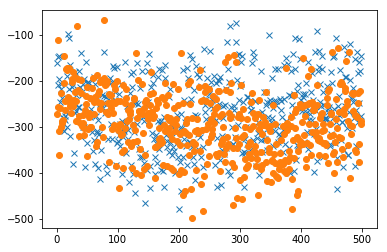

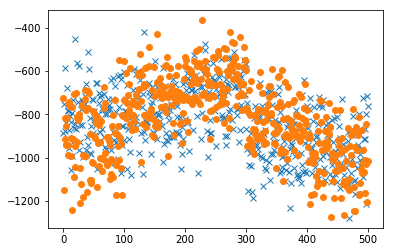

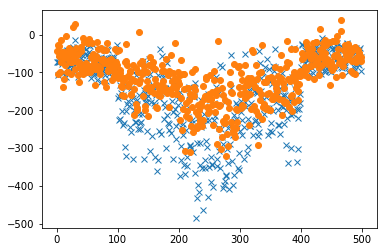

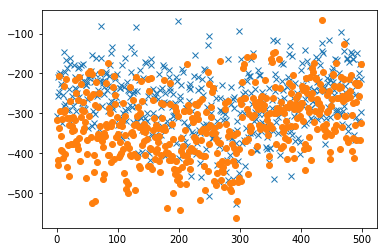

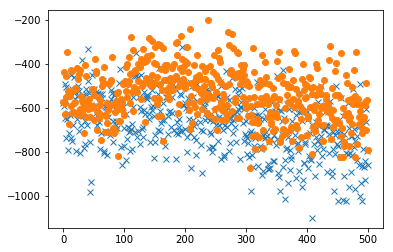

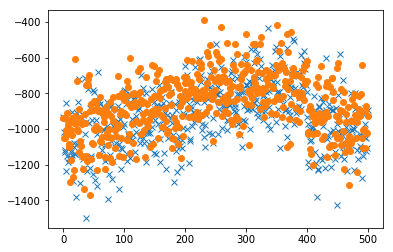

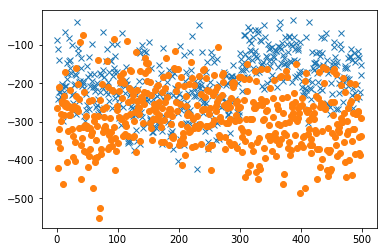

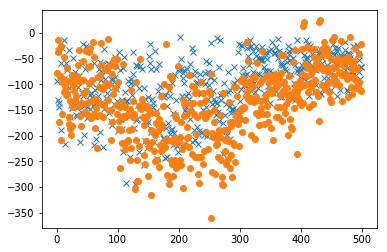

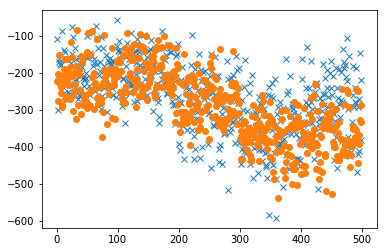

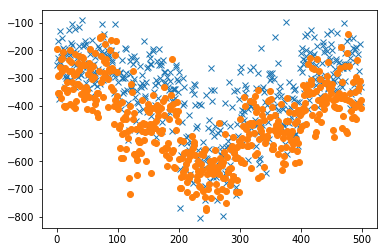

In [64]:
for n in range(10):
    plt.plot(y[n],'x')
    plt.plot(y_[n],'o')
    plt.show()

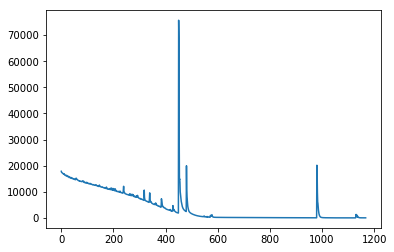

In [46]:
plt.plot(losses[50:])